# *New York, New York*:
## Trashy Trends in the City that Never Sleeps, 2005-2023
by Pete Smith

### Motivation

There's a lot of trash (or so I've been told). Unless you are Oscar the Grouch and literally live in a trash can, you probably don't like trash. On that note, does Oscar the Grouch even like trash? Maybe living in a trash can is why he's so *grouchy* (ha, see what I did there?). Maybe if he just tried to live a little more like Cookie Monster then things would be different.

But wait - you're never going to see this plot twist coming. What if all of the trash from Cookie Monster's cookies is what Oscar the Grouch lives in? Are there feuds between them on Sesame Street? I have no idea. But, I do know that no one likes trash, and that's the important point.

New York City is a large city. After all, it's called the Big Apple, not the Medium Apple and *certainly* not the Little Apple. That would be outrageous. As such, it produces a Big Apple amount of trash. Naturally, such large amounts of trash also produce large amounts of data, just like these large amounts of words will hopefully get me an A on this project.

Analyzing this data, then, is exceedingly important. Firstly, it can help manage ongoing space issues regarding waste management. In places like New York City that simply do not have the space for landfills, knowing exactly what is being thrown away and being able to predict with relative accuracy what will be thrown away is extremely important. Furthermore, understanding what is being thrown away can help in determining how effective various environmental efforts are, and what aspects of those efforts need to be worked on in order to create a greener future.

The data in this project was provided by the New York Department of Sanitation (DSNY). I would thank them for the data, however there are too many issues with the data that I had to address later in this project for me to want to extend my thanks at this current time. If they would like me to thank them, then they should buy me an iced latte first, or take me out to dinner at a fancy restaurant or something.

For further details on the specifics of the data, please visit the following link:

    https://data.cityofnewyork.us/dataset/DSNY-Waste-Characterization-Comparative-Results/bibp-6ff7/about_data

### Preliminary Code

Firstly, there isn't really much that can be done without the use of libraries. Or, I guess you *could* do everything without libraries, but why? People have already made these libraries for a reason, so let's use them.

In [1086]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

### Data Collection

Now comes the time to load in the data. I pre-downloaded the data for convenience's sake. It is available at the following link:

    https://catalog.data.gov/dataset/dsny-waste-characterization-comparative-results

Immediately displaying the table will help to identify certain issues with the data that will need to be addressed later.

For the sake of saving space, I will only use `df.head(5)` here. However, larger ranges can be used instead or entirely different row selections can be used.

In [1087]:
df = pd.read_csv("./DSNY_Waste_Characterization_-_Comparative_Results.csv")

df.head(5)

,Year,Material Group,Comparative Category,DSNY Diversion Summary Category,Aggregate Percent,Refuse Percent,"MGP (Metal, Glass, Plastic) Percent",Paper Percent,Organics Percent,"Generator (Residential, Schools, NYCHA)"
0,2023,Paper,Newspaper,Designated Paper,0.8%,0.005,0.4%,4.8%,0.0%,Residential
1,2023,Paper,Plain OCC/Kraft Paper,Designated Paper,7.2%,0.022,2.8%,56.6%,0.2%,Residential
2,2023,Paper,High Grade Paper,Designated Paper,0.4%,0.003,0.1%,1.3%,0.0%,Residential
3,2023,Paper,Mixed Low Grade Paper,Designated Paper,7.4%,0.062,3.3%,22.5%,0.2%,Residential
4,2023,Paper,Paper: Compostable/Soiled/Waxed OCC/Kraft,Organics Suitable for Composting,9.0%,0.105,2.4%,2.9%,0.8%,Residential


### Data Processing

Upon review different parts of the table with different techniques as discussed above, there is some messiness in the data. Unknown values appear to be denoted as '-' in the table. This will be... unfortunate... if it isn't fixed because '-' cannot be cast to an integer, float, or other number-like type. Mixing numbers and strings would make things exceedingly difficult going forward, so at this point '-' needs to be replaced with Numpy's NaN value.

As a way of showing this, I have included summing the "Aggregate Percent" column in the CSV both before and after the '-' was changed to NaN.

In [1088]:
try:
    df["Aggregate Percent"] = df["Aggregate Percent"].str.rstrip("%").astype("float")
    total = df["Aggregate Percent"].sum()
except:
    print("It doesn't work before changing '-' to NaN")

df.replace("-", np.nan, inplace=True)

df["Aggregate Percent"] = df["Aggregate Percent"].str.rstrip("%").astype("float")
total = df["Aggregate Percent"].sum()
print("No error after changing '-' to NaN")

df.head(5)

It doesn't work before changing '-' to NaN
No error after changing '-' to NaN


,Year,Material Group,Comparative Category,DSNY Diversion Summary Category,Aggregate Percent,Refuse Percent,"MGP (Metal, Glass, Plastic) Percent",Paper Percent,Organics Percent,"Generator (Residential, Schools, NYCHA)"
0,2023,Paper,Newspaper,Designated Paper,0.8,0.005,0.4%,4.8%,0.0%,Residential
1,2023,Paper,Plain OCC/Kraft Paper,Designated Paper,7.2,0.022,2.8%,56.6%,0.2%,Residential
2,2023,Paper,High Grade Paper,Designated Paper,0.4,0.003,0.1%,1.3%,0.0%,Residential
3,2023,Paper,Mixed Low Grade Paper,Designated Paper,7.4,0.062,3.3%,22.5%,0.2%,Residential
4,2023,Paper,Paper: Compostable/Soiled/Waxed OCC/Kraft,Organics Suitable for Composting,9.0,0.105,2.4%,2.9%,0.8%,Residential


At this point, it might also be helpful to remove the percent signs from all of the other columns that have them. This can be done more or less the same as the example from before.

Additionally, the "Refuse Percent" column appears to be formatted as the decimal value rather than the percent format. E.g., instead of 20%, it would say 0.20. This needs to be standardized as well, which is just a matter of multiplying it by 100 to match its scale with the rest of the percent columns.

Lastly for this aspect, the combined values for each year in "Aggregate Percent" do not always add up to 100, so they need to be normalized to that. Doing it here (before creating `simpleDf`) will also allow these changes to easily propagate to the new dataframe that will be created later. This also has to be done for the other percent columns.

In [1089]:
df["MGP (Metal, Glass, Plastic) Percent"] = df["MGP (Metal, Glass, Plastic) Percent"].\
    str.rstrip("%").astype("float")
df["Paper Percent"] = df["Paper Percent"].str.rstrip("%").astype("float")
df["Organics Percent"] = df["Organics Percent"].str.rstrip("%").astype("float")

df["Refuse Percent"] = df["Refuse Percent"] * 100

for each in ["Aggregate Percent", "Refuse Percent", "MGP (Metal, Glass, Plastic) Percent", \
             "Paper Percent", "Organics Percent"]:
    total2005 = df.loc[df["Year"] == 2005, each].sum()
    total2013 = df.loc[df["Year"] == 2013, each].sum()
    total2017 = df.loc[df["Year"] == 2017, each].sum()
    total2023 = df.loc[df["Year"] == 2023, each].sum()

    df.loc[df["Year"] == 2005, each] = df.loc[df["Year"] == 2005, each] / total2005 * 100
    df.loc[df["Year"] == 2013, each] = df.loc[df["Year"] == 2013, each] / total2013 * 100
    df.loc[df["Year"] == 2017, each] = df.loc[df["Year"] == 2017, each] / total2017 * 100
    df.loc[df["Year"] == 2023, each] = df.loc[df["Year"] == 2023, each] / total2023 * 100

df.head()

,Year,Material Group,Comparative Category,DSNY Diversion Summary Category,Aggregate Percent,Refuse Percent,"MGP (Metal, Glass, Plastic) Percent",Paper Percent,Organics Percent,"Generator (Residential, Schools, NYCHA)"
0,2023,Paper,Newspaper,Designated Paper,0.400400,0.166667,0.200401,2.396405,0.00000,Residential
1,2023,Paper,Plain OCC/Kraft Paper,Designated Paper,3.603604,0.733333,1.402806,28.257614,0.10005,Residential
2,2023,Paper,High Grade Paper,Designated Paper,0.200200,0.100000,0.050100,0.649026,0.00000,Residential
3,2023,Paper,Mixed Low Grade Paper,Designated Paper,3.703704,2.066667,1.653307,11.233150,0.10005,Residential
4,2023,Paper,Paper: Compostable/Soiled/Waxed OCC/Kraft,Organics Suitable for Composting,4.504505,3.500000,1.202405,1.447828,0.40020,Residential


Another thing that needs to be changed in the "Material Group" column is "C&D". Interestingly, DSNY had some inconsistencies, labeling some of their data as "Construction & Demolition" and some as "C&D." To fix this, I will be be changing the "C&D" values to "Construction & Demotition." While these rows are joined with the rows that already had "Construction & Demolition" in their "Material Group," those changes are only applied to `simpleDf`. I do that here as well so that this change is also applied to `df`.

In [1090]:
df.loc[df["Material Group"] == "C&D", "Material Group"] = "Construction & Demolition"
df = df.groupby(["Year", "Material Group"]).sum().reset_index()

There is also decent amount of data that I simply will not need. The primary culprit of this is waste categorization - there are currently three columns for categorizing types of waste. While each has a different level of specificity and a different purpose, the only one that is likely to be needed in this project is the primary category, or the "Material Group" column. It is, however, important to keep a copy of the original dataframe just in case that data is needed at some point. So for these purposes, `df` will remain as the original dataframe and `simpleDf` will be the dataframe with only one category. As part of putting it into one category, the values will need to be summed as well. The "Generator..." column will necessarily have to be dropped as well, because there is no way to accurately combine different classes in it.

An unintended side effect of this is also that all of the columns fit on my screen. While this may change depending on what a given person's screen size is, it is an important consideration to make. Even if you can scroll horizontally, it can be very helpful to have a table that is small enough to fit all of the columns on one screen without scrolling.

In [1091]:
simpleDf = df.copy()
simpleDf.drop(columns=["Comparative Category", "DSNY Diversion Summary Category", "Generator (Residential, Schools, NYCHA)"], inplace=True)
simpleDf = simpleDf.groupby(["Year", "Material Group"]).sum().reset_index()

simpleDf.head()

,Year,Material Group,Aggregate Percent,Refuse Percent,"MGP (Metal, Glass, Plastic) Percent",Paper Percent,Organics Percent
0,2005,Construction & Demolition,5.189621,6.419258,0.400400,0.100301,0.0
1,2005,E-Waste,0.698603,0.702106,0.900901,0.000000,0.0
2,2005,Glass,4.491018,2.607823,33.033033,0.000000,0.0
3,2005,Harmful Household Products,0.199601,0.300903,0.300300,0.000000,0.0
4,2005,Metal,5.688623,3.911735,32.532533,0.000000,0.0


### Exploratory Data Analysis and Data Visualization

The first part of analyzing this data is visualizing it. By visualizing it, trends will be more noticeable. There are practically limitless ways that this data can be visualized; this tutorial will look at the main ways that will be useful for analyzing the data, and will explore the data based on a number of factors such as trash type and time.

#### Trash by Type: 2005

This section will look specifically at the data from 2005. By using the `simpleDf` from before, I will be using data that I have already slightly processed, allowing me to better display the data in a way that will not be visually overwhelming. Specifically, this graph will put percents against waste types, separating types of percents (aggregate, refuse, paper, etc.) as different bars.

Doing this will create a good balance of having lots of information, while at the same time still being easily understandable.

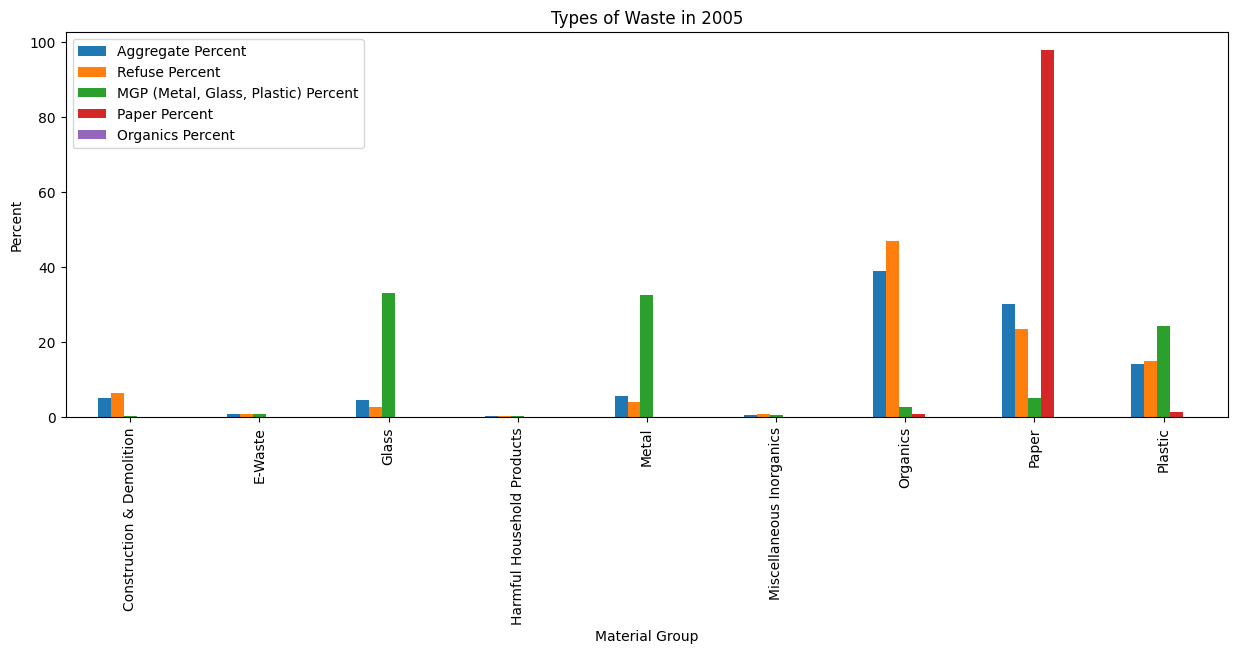

In [1092]:
# take the 2005 data from simpleDf
df2005 = simpleDf[simpleDf["Year"] == 2005]
df2005.set_index("Material Group", inplace=True)

df2005Plot = df2005[["Aggregate Percent", "Refuse Percent", \
                      "MGP (Metal, Glass, Plastic) Percent", "Paper Percent", \
                      "Organics Percent"]]

df2005Plot.plot(kind="bar", figsize=(15, 5))

plt.xlabel("Material Group")
plt.ylabel("Percent")
plt.title("Types of Waste in 2005")
plt.xticks(rotation=90)
plt.legend()

plt.show()

### Trash by Type: 2013, 2017, 2023

Now that I have established *how* display this data, it's time to display it it for the rest of the table. To do this, I can just wrap the code from the 2005 section in a for loop and iterate on the remaining years.

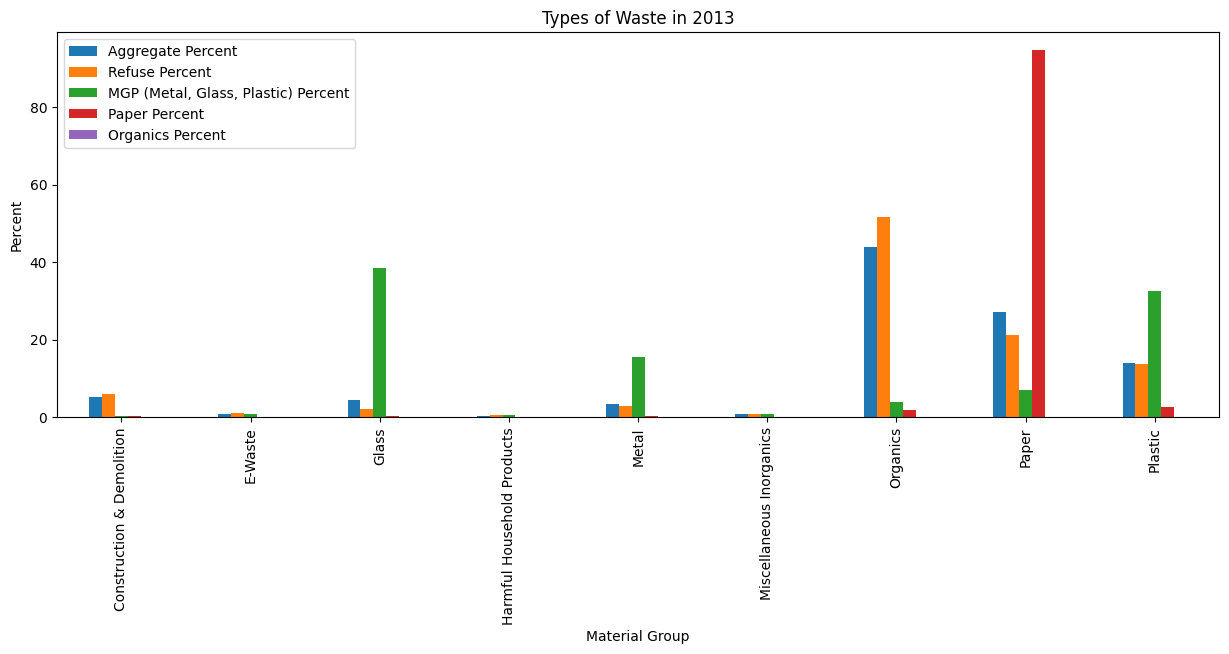

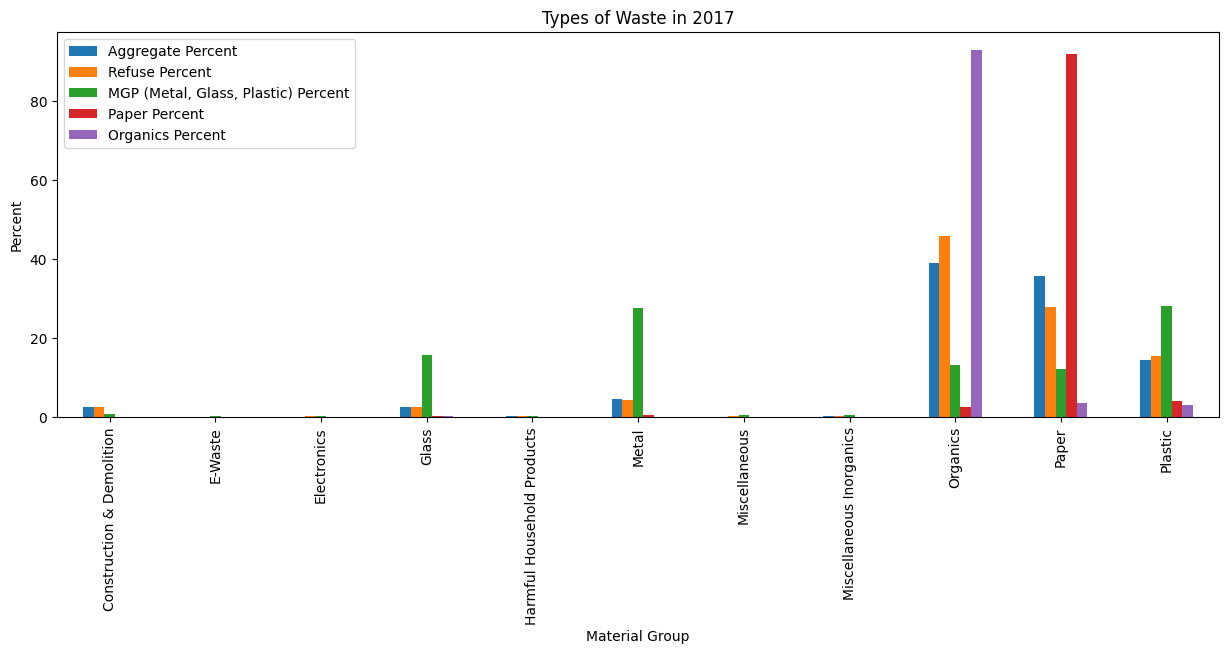

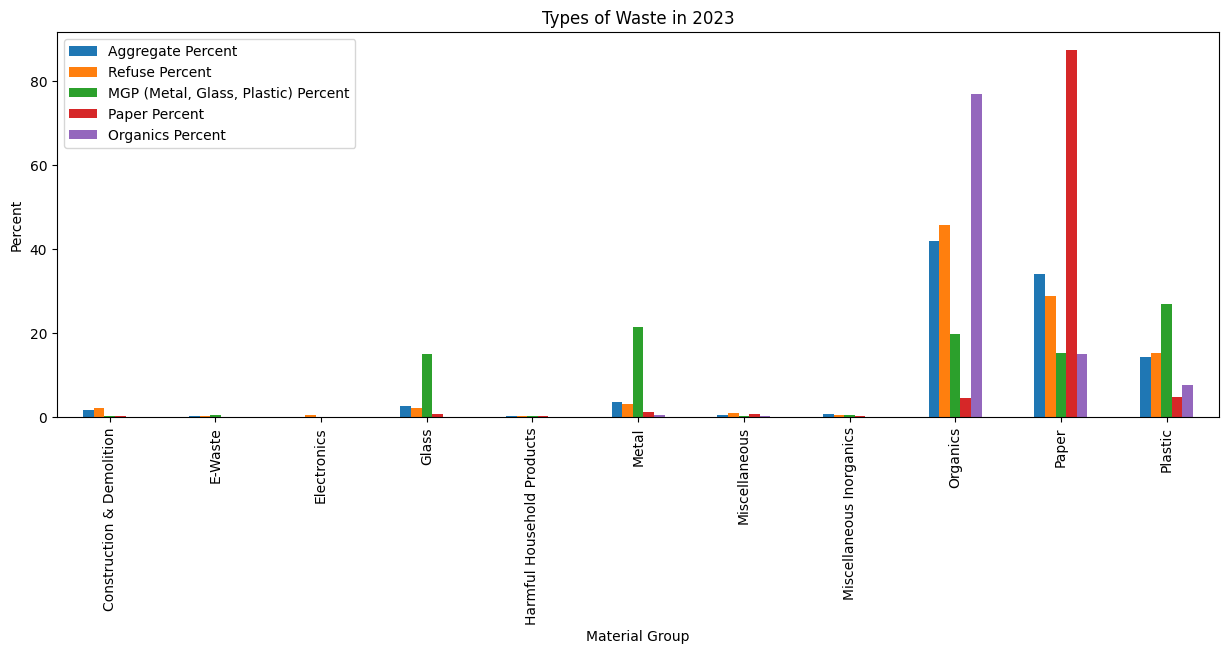

In [1093]:
for each in [2013, 2017, 2023]:
    tempDf = simpleDf[simpleDf["Year"] == each]
    tempDf.set_index("Material Group", inplace=True)

    tempDfPlot = tempDf[["Aggregate Percent", "Refuse Percent", \
                          "MGP (Metal, Glass, Plastic) Percent", "Paper Percent", \
                          "Organics Percent"]]

    tempDfPlot.plot(kind="bar", figsize=(15, 5))

    plt.xlabel("Material Group")
    plt.ylabel("Percent")
    plt.title("Types of Waste in " + str(each))
    plt.xticks(rotation=90)
    plt.legend()

    plt.show()

There is already some information that can be extracted. The first thing that I noticed while looking at these graphs was that there was no data listed under "Organics" before 2017. While this is something that can certainly be seen by just looking at the table (or even at the CSV file itself), displaying it like this is a great example of the strenghts of graph visualization. To me, this shows the shifting priorities seen in society surrounding waste management. While there had already been pushes to increase recycling and paper use (as opposed to plastic bags, etc.) in the past, a more recent trend has been pushing toward a compostable future. Notably, this has been present at the University of Maryland, with virtually every restroom having a compost bin due to the high volume of paper towels that are used daily.

By including organics in their 2017 study, DSNY further recognized the growing importance of organic waste and compost in waste management and, especially in dense areas such as New York City, in dealing with such large amounts of waste.

### Trash Types through Time, 2005-2023

Another important aspect to look at is how the overall proportions of waste have changed over time. Fortunately, there's really only one plot that has to be made this time, as opposed to four with the previous graphs.

This graph basically shows the proportions of waste in each year. In this case, I think using a line graph is a better idea, and will better show how each type of waste compares to other types of waste.

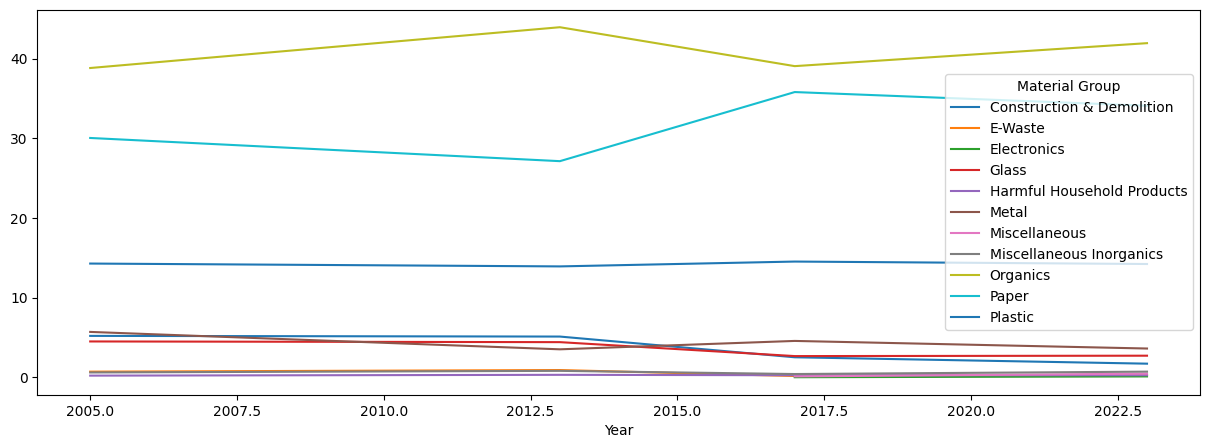

In [1094]:
trashYearDf = simpleDf.copy()
trashYearDf = trashYearDf.pivot(index="Year", columns="Material Group", values="Aggregate Percent")
# assigning to a variable to suppress unnecessary output
_ = trashYearDf.plot(kind="line", figsize=(15, 5))

This graph also shows some interesting data. Firstly, since I'm still sort of thinking about the organics aspect of the previous graphs and how those weren't available before 2017, I thought it was interesting to see that organics as a category of waste *were* being tracked before 2017. This graph displays categories of waste, rather than percents, which were displayed in the previous graphs and, for DSNY purposes, were tracked differently. So while organics were tracked to some extent before 2017, it was only starting in 2017 that it was deemed important enough to establish as a different statistic for percentage purposes.

Overall, things seem pretty stable. I'm not entirely sure what I expected, to be honest, but I guess with a city that big, things sort of tend to average out. What I did notice, however, is that paper and organic waste seemed to change inversely from 2013 to 2017 and from 2017 to 2023. From 2013 to 2017, the proportion of paper waste increased by roughly 10%, while the proportion of organic waste decreased by a little less than 10%. While it didn't quite go back to the previous numbers from 2017 to 2023, it did go on that trend - paper waste went back down, however not quite matching the 10% from before - it was on a downward trend to "correct" the deviance from the previous time period, however it did not fully make up for it. Similarly, organic waste increased by a couple of percents from 2017 to 2023. As with paper waste, it didn't quite make up for the changes seen in the previous time period, however it did start a trend of "fixing" the previous change.

### Violins? I play the trumpet!

The last graph that I will display here is a violin plot of years and aggregate percentages. As with the other graphs, this doesn't display much that can't be determined from just looking at the existing data, or even looking at the previous graphs. However, it shows distributions and, as such, may allow people to make different insights that may be valuable.

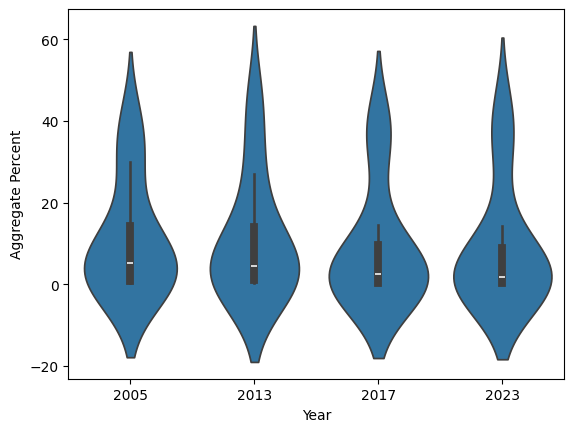

In [1095]:
meltedDf = trashYearDf.T.melt(var_name='Year', value_name='Aggregate Percent')

_ = sns.violinplot(x='Year', y='Aggregate Percent', data=meltedDf)

As stated above, much of what this shows can already be determined from previous data. However, the unique shapes of violin plots allows me to make certain insights into the data. For example, each of the four violins (one for each year in the table) is unimodal and skewed toward lower values. This gives me some important information - while there are waste types like paper and organics that comprise larger portions of the overall waste, they are a relative minority out of the total number of waste types. The majority of waste types make up smaller portions of the overall amount of waste - roughly 0% to 15%.

This does, however, change in 2017 and 2023, where it actually gets even more concentrated in the general area from 0% to 15%. This implies more diversity in the types of materials that are being produced and thus disposed of. While this change is relatively subtle, it would be interesting to see if it is a trend that will continue 5, 10, or 15 years from now, or perhaps even longer.

### Analysis, Hypothesis Testing, and Machine Learning

Let's start with some good old linear regression. Yay!

A good thing to start with would be finding a line of best fit for each of the five most common categories of waste.

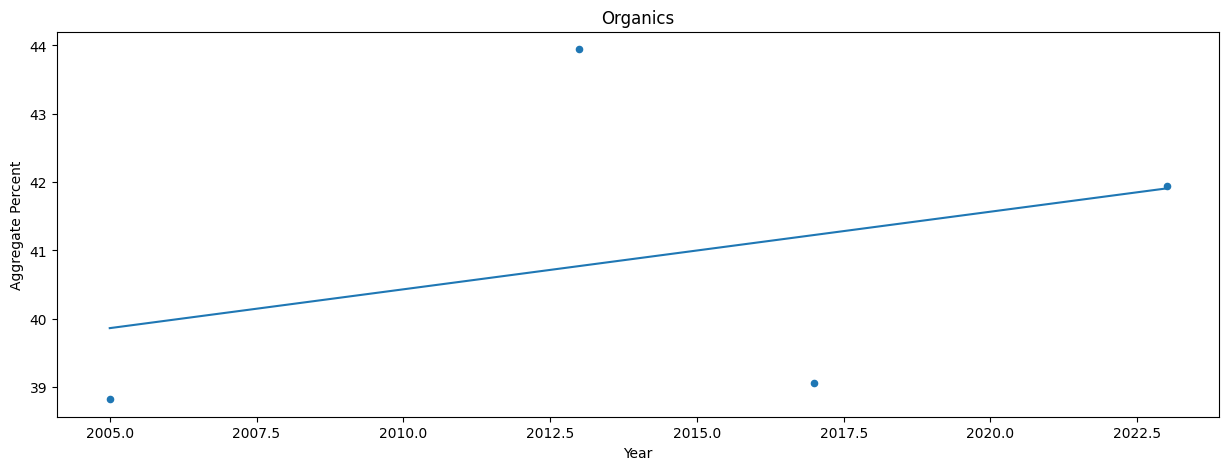

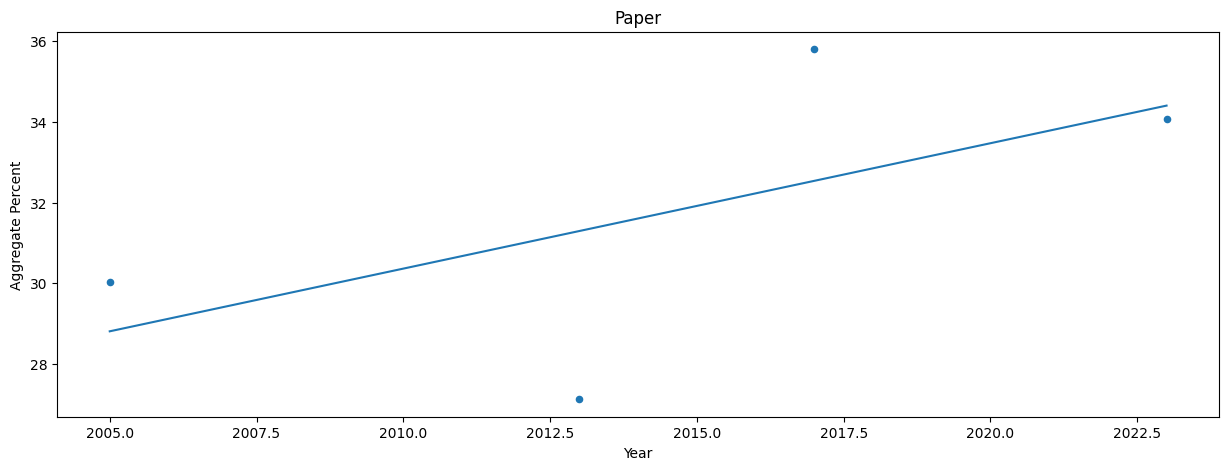

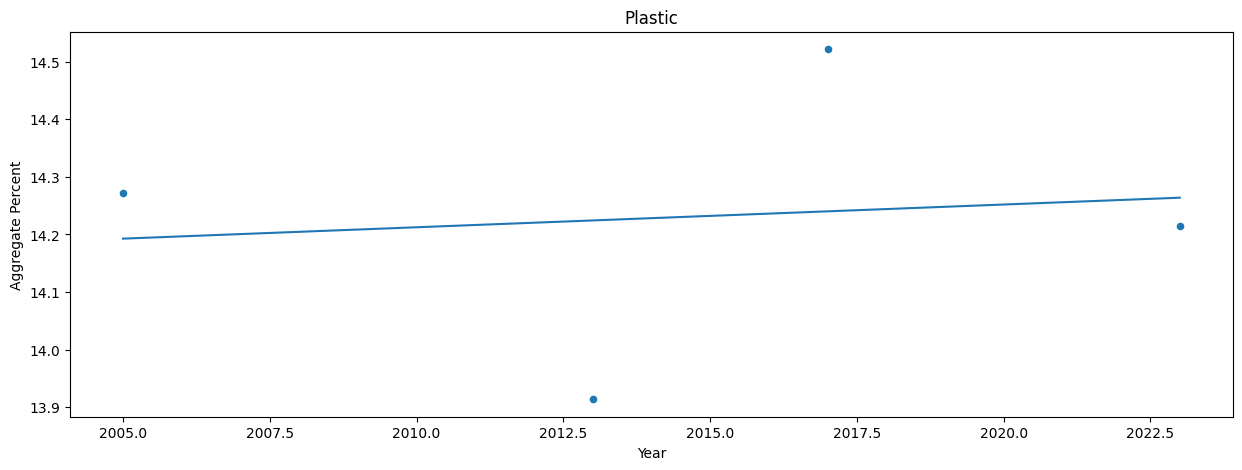

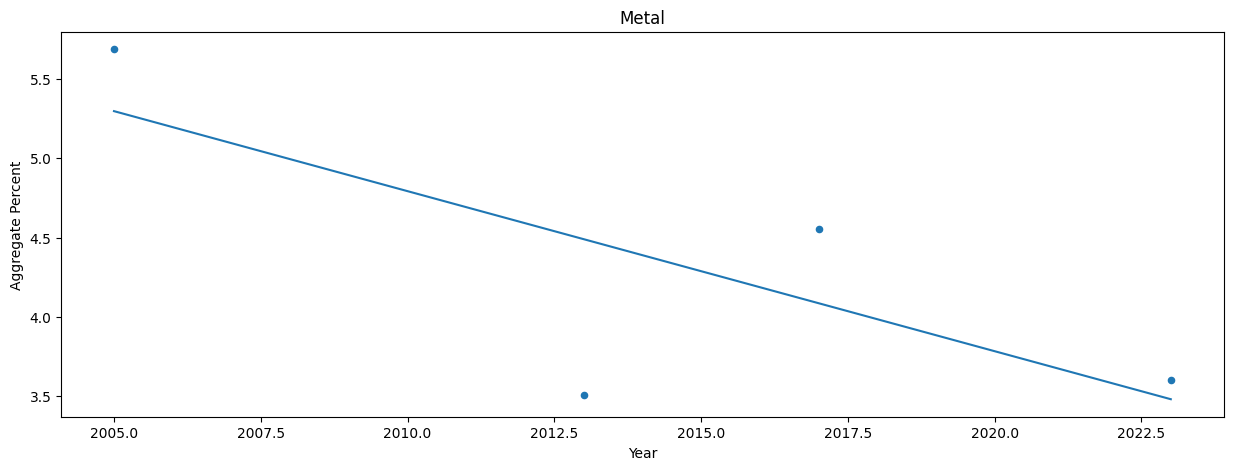

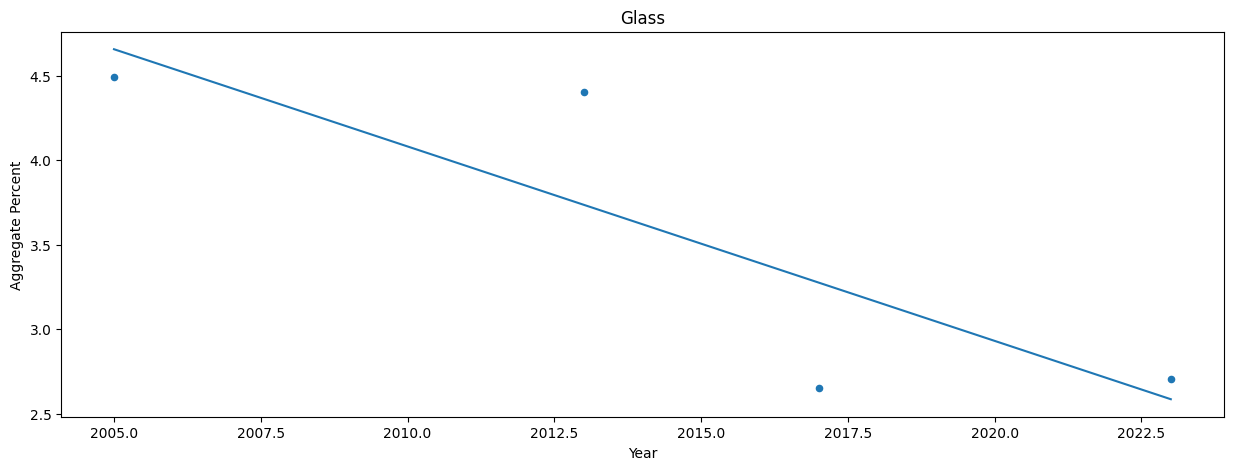

In [1096]:
items = ["Organics", "Paper", "Plastic", "Metal", "Glass"]

lines = []
simpleDf.insert(7, "aggrPercPredicted", 0)
for each in items:
    temp = simpleDf[simpleDf["Material Group"] == each]
    aggrRegrLine = LinearRegression().fit(temp[["Year"]], temp["Aggregate Percent"])
    temp["aggrPercPredicted"] = aggrRegrLine.predict(temp[["Year"]])
    simpleDf.update(temp)
    
    temp.plot.scatter(x="Year", y="Aggregate Percent", title=each, figsize=(15, 5))
    temp.plot.line(x="Year", y="aggrPercPredicted", ax=plt.gca(), legend=False)

### Insight and Policy Decision